## Setup

In [156]:
#@title Import modules
%tensorflow_version 2.x

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

tf.keras.backend.set_floatx('float32')

print("Imported modules")

Imported modules


In [157]:
#@title Import data
train_df = pd.read_csv("http://seppe.net/aa/assignment2/data/train.csv", sep=",")
test_df = pd.read_csv("http://seppe.net/aa/assignment2/data/test.csv", sep=",")

train_df = train_df.reindex(
np.random.permutation(train_df.index))
print("Imported data")

Imported data


In [158]:
print(train_df.columns)

Index(['id', 'name', 'brand', 'base_name', 'screen_size', 'pixels_x',
       'pixels_y', 'screen_surface', 'touchscreen', 'cpu', 'cpu_details',
       'detachable_keyboard', 'discrete_gpu', 'gpu', 'os', 'os_details', 'ram',
       'ssd', 'storage', 'weight', 'min_price', 'max_price'],
      dtype='object')


In [159]:
#@title Fill in some missing values.
mean_weight = train_df["weight"].mean()
train_df["weight"].loc[train_df["weight"].isnull()] = mean_weight
train_df["detachable_keyboard"].loc[train_df["detachable_keyboard"].isnull()] = 0
print("Filled missing values")

Filled missing values


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
# Create artificial features
train_df["pixel_density"] = ((train_df["pixels_x"]*train_df["pixels_y"])/(1000*train_df["screen_size"]*train_df["screen_size"]))

In [163]:
#@title Normalize data
train_df_norm = train_df.copy()
catvars = ["touchscreen" , "detachable_keyboard" , "discrete_gpu"]
numvars = ["screen_size" , "pixel_density" , "ram" , "ssd" , "storage" , "weight"]

for item in numvars:
  train_df_norm[item] = (train_df[item] - train_df[item].mean())/train_df[item].std()

train_df_norm.pop('pixels_x')
train_df_norm.pop('pixels_y')

print("Normalized data")
train_df_norm.describe()

Normalized data


,id,screen_size,touchscreen,detachable_keyboard,discrete_gpu,ram,ssd,storage,weight,min_price,max_price,pixel_density
count,510.0,510.0,510.0,510.0,510.0,510.0,510.0,510.0,510.0,510.0,510.0,510.0
mean,21748.8,-0.0,0.3,0.0,0.3,0.0,-0.0,0.0,0.0,793.7,829.2,0.0
std,7344.3,1.0,0.5,0.2,0.5,1.0,1.0,1.0,1.0,543.6,570.1,1.0
min,3841.0,-2.8,0.0,0.0,0.0,-1.2,-0.8,-1.1,-2.1,69.0,76.0,-0.7
25%,18547.8,-0.8,0.0,0.0,0.0,-0.9,-0.8,-0.9,-0.9,380.1,399.2,-0.6
50%,23196.5,0.6,0.0,0.0,0.0,-0.3,-0.3,-0.1,0.1,638.5,649.0,-0.3
75%,27881.5,0.6,1.0,0.0,1.0,1.0,0.2,0.8,0.5,1099.7,1179.7,-0.0
max,31422.0,1.7,1.0,1.0,1.0,8.7,7.4,6.6,4.1,2999.1,2999.1,4.2


In [164]:
#@title Create feature column
# selected_features = []
feature_columns = []
my_vars = catvars+numvars

# for item in my_vars:
#   selected_features.append(my_dataframe_norm[item])

# processed_features = selected_features.copy()
# processed_features["pixel_density"] = ((my_dataframe["pixels_x"]*my_dataframe["pixels_y"])/(1000*my_dataframe["screen_size"]*my_dataframe["screen_size"]))

for item in my_vars:
  feature_columns.append(tf.feature_column.numeric_column(item))

# weight = tf.feature_column.numeric_column("weight")
# feature_columns.append(weight)

my_feature_layer = layers.DenseFeatures(feature_columns)
print("Created feature column")

Created feature column


In [246]:
#@title Define the plotting function.

def plot_the_loss_curve(epochs, mae_training, mae_validation):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs[1:], mae_training[1:], label="Training Loss")
  plt.plot(epochs[1:], mae_validation[1:], label="Validation Loss")
  plt.legend()
  
  # We're not going to plot the first epoch, since the loss on the first epoch
  # is often substantially greater than the loss for other epochs.
  merged_mae_lists = mae_training[1:] + mae_validation[1:]
  highest_loss = max(merged_mae_lists)
  lowest_loss = min(merged_mae_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05) - 800
  bottom_of_y_axis = lowest_loss - (delta * 0.05) - 500
   
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show()  

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


In [247]:
#@title Define functions to create and train a linear regression model
def create_model(my_learning_rate, feature_layer):
  model = tf.keras.models.Sequential()
  model.add(feature_layer)
  # model.add(tf.keras.layers.Dense(units=20, 
  #                                 activation='relu', 
  #                                 name='Hidden1'))
  # model.add(tf.keras.layers.Dense(units=12, 
  #                                 activation='relu', 
  #                                 name='Hidden2'))
  model.add(tf.keras.layers.Dense(units=2))

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model

def train_model(model, dataset, epochs, batch_size, validation_split,
                label_name1, label_name2):
  """Feed a dataset into the model in order to train it."""

  # Split the dataset into features and label.
  # features = {name:np.array(value) for name, value in dataset.items()}
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array([features.pop(label_name1),features.pop(label_name2)]).T
  # label = np.array(features.pop(label_name))

  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True,
                      validation_split = validation_split)
  print(history.history.keys())
  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]

  return epochs, rmse, hist   

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


Epoch 1/300
5/5 [==============================] - 0s 30ms/step - loss: 929389.1250 - root_mean_squared_error: 1001.9169 - val_loss: 1034131.1875 - val_root_mean_squared_error: 850.7519
Epoch 2/300
5/5 [==============================] - 0s 9ms/step - loss: 1084118.3750 - root_mean_squared_error: 983.0293 - val_loss: 998821.2500 - val_root_mean_squared_error: 837.5308
Epoch 3/300
5/5 [==============================] - 0s 9ms/step - loss: 896619.3125 - root_mean_squared_error: 969.2053 - val_loss: 967319.9375 - val_root_mean_squared_error: 825.6580
Epoch 4/300
5/5 [==============================] - 0s 9ms/step - loss: 939707.3125 - root_mean_squared_error: 956.7054 - val_loss: 942036.0000 - val_root_mean_squared_error: 815.7133
Epoch 5/300
5/5 [==============================] - 0s 10ms/step - loss: 882943.8750 - root_mean_squared_error: 945.7435 - val_loss: 914237.8750 - val_root_mean_squared_error: 804.9747
Epoch 6/300
5/5 [==============================] - 0s 10ms/step - loss: 840951.8

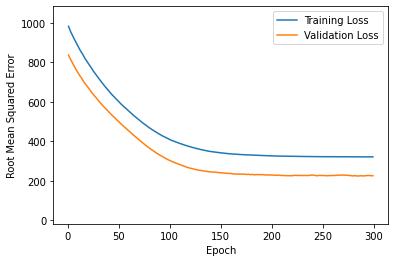

In [248]:
# The following variables are the hyperparameters.
learning_rate = .8
epochs = 300
batch_size = 100
validation_split = 0.2
label_name1 = "min_price"
label_name2 = "max_price"

all_vars = my_vars.copy()
all_vars.extend([label_name1,label_name2])
train_df_small = train_df_norm[all_vars]

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
epochs, rmse, hist = train_model(my_model, train_df_small, epochs, batch_size, validation_split, label_name1, label_name2)
list_of_metrics_to_plot = ["root_mean_squared_error"]
# plot_the_loss_curve(epochs, mse)
plot_the_loss_curve(epochs, hist["root_mean_squared_error"], 
                    hist["val_root_mean_squared_error"])

In [228]:
train_df_x = {name:np.array(value) for name, value in train_df_small[1:10].items()}
predictions = my_model.predict(train_df_x)
predictions = np.around(predictions)
targets = np.array([train_df_x[label_name1],train_df_x[label_name2]]).T
print(np.c_[predictions, targets])

[[ 575.    595.    559.    559.  ]
 [ 520.    535.    186.08  238.  ]
 [ 827.    873.    317.88  317.88]
 [1844.   1992.   1079.99 1140.32]
 [1077.   1126.   1499.77 1499.77]
 [ 282.    288.    165.    168.88]
 [ 276.    291.    165.05  165.05]
 [1190.   1267.    799.9   799.9 ]
 [ 495.    528.    379.99  379.99]]


Because we're now working with multiple input features, let's modularize our code for configuring feature columns into a separate function. (For now, this code is fairly simple, as all our features are numeric, but we'll build on this code as we use other types of features in future exercises.)

Defined the create_model and train_model functions.
Epoch 1/300
5/5 [==============================] - 0s 35ms/step - loss: 1069053.0000 - root_mean_squared_error: 1009.7968 - val_loss: 1087134.7500 - val_root_mean_squared_error: 869.8962
Epoch 2/300
5/5 [==============================] - 0s 11ms/step - loss: 969670.1875 - root_mean_squared_error: 1008.4653 - val_loss: 1084286.7500 - val_root_mean_squared_error: 868.5504
Epoch 3/300
5/5 [==============================] - 0s 10ms/step - loss: 1172559.7500 - root_mean_squared_error: 1006.9357 - val_loss: 1079555.7500 - val_root_mean_squared_error: 866.4575
Epoch 4/300
5/5 [==============================] - 0s 10ms/step - loss: 1006200.1875 - root_mean_squared_error: 1004.6829 - val_loss: 1074118.7500 - val_root_mean_squared_error: 864.1417
Epoch 5/300
5/5 [==============================] - 0s 10ms/step - loss: 1114489.2500 - root_mean_squared_error: 1002.0143 - val_loss: 1066242.1250 - val_root_mean_squared_error: 860.8723
Epoch 6/300
5/

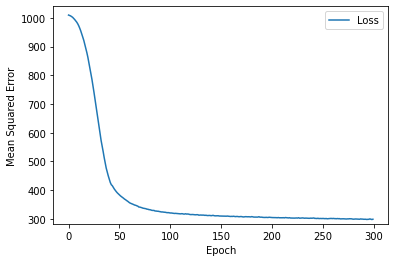

[[ 676.    707.    559.    559.  ]
 [ 369.    388.    186.08  238.  ]
 [ 830.    869.    317.88  317.88]
 [1792.   1887.   1079.99 1140.32]
 [1087.   1146.   1499.77 1499.77]
 [ 248.    264.    165.    168.88]
 [ 319.    340.    165.05  165.05]
 [1161.   1218.    799.9   799.9 ]
 [ 470.    495.    379.99  379.99]]


In [231]:
##@title Define functions to create and train a linear regression model
def create_model(my_learning_rate, feature_layer):
  model = tf.keras.models.Sequential()
  model.add(feature_layer)
  model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu', 
                                  name='Hidden1'))
  model.add(tf.keras.layers.Dense(units=12, 
                                  activation='relu', 
                                  name='Hidden2'))
  model.add(tf.keras.layers.Dense(units=2))

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model

def train_model(model, dataset, epochs, batch_size, validation_split,
                label_name1, label_name2):
  """Feed a dataset into the model in order to train it."""

  # Split the dataset into features and label.
  # features = {name:np.array(value) for name, value in dataset.items()}
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array([features.pop(label_name1),features.pop(label_name2)]).T
  # label = np.array(features.pop(label_name))

  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True,
                      validation_split = validation_split)
  print(history.history.keys())
  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]

  return epochs, rmse   

print("Defined the create_model and train_model functions.")

# The following variables are the hyperparameters.
learning_rate = .005
epochs = 300
batch_size = 100
validation_split = 0.2
label_name1 = "min_price"
label_name2 = "max_price"

all_vars = my_vars.copy()
all_vars.extend([label_name1,label_name2])
train_df_small = train_df_norm[all_vars]

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
epochs, mse = train_model(my_model, train_df_small, epochs, batch_size, validation_split, label_name1, label_name2)
plot_the_loss_curve(epochs, mse)

train_df_x = {name:np.array(value) for name, value in train_df_small[1:10].items()}
predictions = my_model.predict(train_df_x)
predictions = np.around(predictions)
targets = np.array([train_df_x[label_name1],train_df_x[label_name2]]).T
print(np.c_[predictions, targets])

In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model of multiple features.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["average_price"], 
      batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["average_price"], 
      num_epochs=1, 
      shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(
      validation_examples, validation_targets["average_price"], 
      num_epochs=1, 
      shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 892.97
  period 01 : 759.89
  period 02 : 659.97
  period 03 : 600.54
  period 04 : 575.42
  period 05 : 558.33
  period 06 : 545.79
  period 07 : 538.12
  period 08 : 532.23
  period 09 : 526.53
Model training finished.


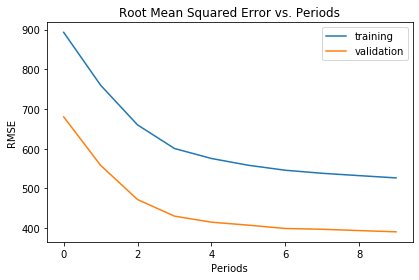

In [0]:
## With discrete features
linear_regressor = train_model(
    learning_rate=0.001,
    steps=500,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 893.13
  period 01 : 759.69
  period 02 : 662.81
  period 03 : 607.79
  period 04 : 575.36
  period 05 : 562.38
  period 06 : 555.04
  period 07 : 548.93
  period 08 : 539.45
  period 09 : 531.37
Model training finished.


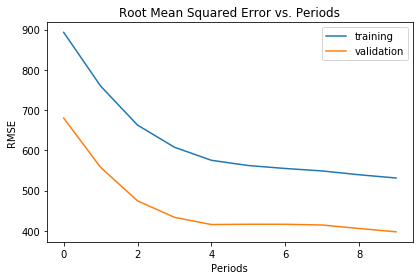

In [0]:
## Without discrete features
linear_regressor = train_model(
    learning_rate=0.001,
    steps=500,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

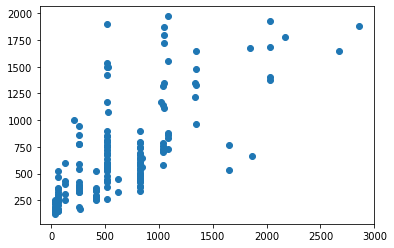

In [0]:
validation_input_function = lambda: my_input_fn(validation_examples,
    validation_targets,
    num_epochs=1,
    shuffle=False)
validation_predictions = linear_regressor.predict(input_fn=validation_input_function)
validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

plt.scatter(validation_predictions,validation_targets)
plt.show()

In [0]:
## With discrete features
  root_mean_squared_error = math.sqrt(
  metrics.mean_squared_error(validation_predictions, validation_targets))
  root_mean_absolute_error = math.sqrt(
  metrics.mean_absolute_error(validation_predictions, validation_targets))
  print("Final RMSE (on test data): %0.2f \nFinal MAE (on test data): %0.2f" % (root_mean_squared_error,root_mean_absolute_error) )

Final RMSE (on test data): 390.71 
Final MAE (on test data): 17.01


In [0]:
## Without discrete features
  root_mean_squared_error = math.sqrt(
  metrics.mean_squared_error(validation_predictions, validation_targets))
  root_mean_absolute_error = math.sqrt(
  metrics.mean_absolute_error(validation_predictions, validation_targets))
  print("Final RMSE (on test data): %0.2f \nFinal MAE (on test data): %0.2f" % (root_mean_squared_error,root_mean_absolute_error) )

Final RMSE (on test data): 397.68 
Final MAE (on test data): 17.22


In [0]:
validation_input_function = lambda: my_input_fn(validation_examples,
    validation_targets,
    num_epochs=1,
    shuffle=False)
evaluation = linear_regressor.evaluate(input_fn=validation_input_function)
for key, value in evaluation.items():
    print(key, value)

average_loss 158152.28
label/mean 682.1436
loss 158152.28
prediction/mean 654.0178
global_step 500


## Task 5: Evaluate on Test Data

We test the model on the test data

In [0]:
test_data = pd.read_csv("http://seppe.net/aa/assignment2/data/test.csv", sep=",")
test_data.describe()

,id,screen_size,pixels_x,pixels_y,touchscreen,detachable_keyboard,discrete_gpu,ram,ssd,storage,weight
count,222.0,222.0,220.0,220.0,222.0,222.0,222.0,222.0,222.0,222.0,221.0
mean,21760.5,14.6,1839.4,1057.1,0.4,0.0,0.3,10.4,223.3,573.4,4.2
std,7343.8,1.6,495.1,320.9,0.5,0.2,0.5,6.8,260.0,488.9,1.3
min,3900.0,10.0,1280.0,768.0,0.0,0.0,0.0,2.0,0.0,16.0,1.1
25%,17743.2,13.3,1366.0,768.0,0.0,0.0,0.0,4.0,0.0,136.0,3.0
50%,23714.5,15.6,1920.0,1080.0,0.0,0.0,0.0,8.0,128.0,500.0,4.3
75%,27110.2,15.6,1920.0,1080.0,1.0,0.0,1.0,16.0,256.0,1000.0,4.8
max,31424.0,17.3,3840.0,2160.0,1.0,1.0,1.0,32.0,1500.0,2500.0,9.7


In [0]:
def my_test_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of multiple features.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
test_examples = preprocess_features(test_data)
test_input_function=lambda: my_input_fn(test_examples,
    num_epochs=1,
    shuffle=False)
test_predictions = linear_regressor.predict(input_fn=test_input_function)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

TypeError: ignored

In [0]:
test_predictions

<generator object Estimator.predict at 0x7fd7139e3200>

In [0]:
[item for item in test_predictions]

NameError: ignored

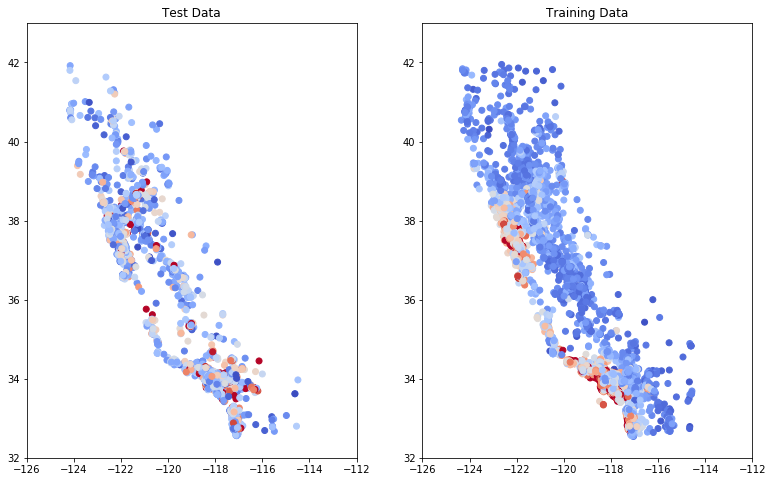

Final RMSE (on test data): 146.24


In [0]:
  plt.figure(figsize=(13, 8))

  ax = plt.subplot(1, 2, 1)
  ax.set_title("Test Data")

  ax.set_autoscaley_on(False)
  ax.set_ylim([32, 43])
  ax.set_autoscalex_on(False)
  ax.set_xlim([-126, -112])
  plt.scatter(test_examples["longitude"],
            test_examples["latitude"],
            cmap="coolwarm",
            c=test_predictions / test_predictions.max())

  ax = plt.subplot(1,2,2)
  ax.set_title("Training Data")

  ax.set_autoscaley_on(False)
  ax.set_ylim([32, 43])
  ax.set_autoscalex_on(False)
  ax.set_xlim([-126, -112])
  plt.scatter(training_examples["longitude"],
            training_examples["latitude"],
            cmap="coolwarm",
            c=training_targets["median_house_value"] / training_targets["median_house_value"].max())

  plt.show()
  root_mean_squared_error = math.sqrt(
  metrics.mean_squared_error(test_predictions, test_targets))
  print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

### Solution

Click below for the solution.

In [0]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")

test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_test_input_fn = lambda: my_input_fn(
      test_examples, 
      test_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)

test_predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

Final RMSE (on test data): 161.52
